In [44]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate as intg

In [51]:
#Notes on conventions
#Right Riemann sums for all integrals to avoid division by 0

#constants
Omega0 = 0.2 #present day matter density in unit of critical density
OmegaLambda = 0.8
Omegak = 1-Omega0-OmegaLambda

deltaz = 0.2 #redshift bin width
z_limit = 8
z_res = 200 #in integration 1 redshift is broken into z_res intervals
gaussian_spread = 0.01
print('z resolution is %1.5f' %(1/z_res))

i = 5
z_i_center = 0.2*(i+1) #the center for the ith redshift bin
z_lowerbound = z_i_center-deltaz/2
z_upperbound = z_i_center+deltaz/2
print("calculating for redshift bin %1.2f - %1.2f" %(z_lowerbound,z_upperbound))

z resolution is 0.00500
calculating for redshift bin 1.10 - 1.30


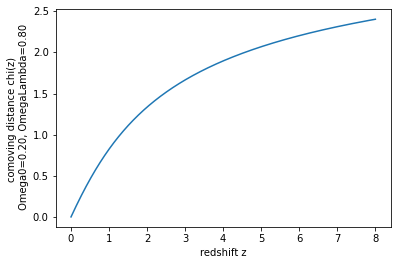

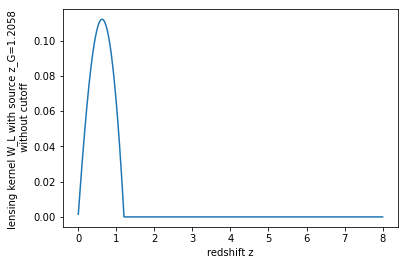

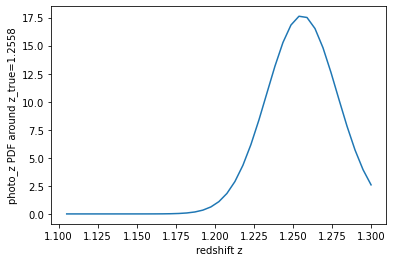

total area under the gaussian curve = 0.957
applying smearing to the ith redshift bin gal distribution, normailization =  20.856039684940296


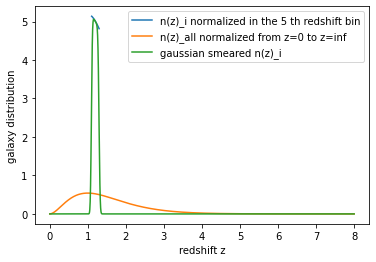

CPU times: user 801 ms, sys: 35.5 ms, total: 837 ms
Wall time: 902 ms


In [52]:
%%time 
#~15sec per redshift bin

#Ranges and values
#n_z_i_list     vs.   z_i_list
#n_z_all_list   vs.   z_list
#chi_list       vs.   z_list
#W_L_list       vs.   z_list x z_list
#W_L_list[i]    =     Lensing kernel for source at z_list[i]
z_list = np.linspace(0,z_limit,z_limit*z_res,dtype='float64')[1:]
z_i_list = np.linspace(z_lowerbound,z_upperbound,int(deltaz*z_res),dtype='float64')[1:]
#throw away the first element to perform right Riemann sum to avoid 0 division

#redshift distributions
def n_z(z):
    return z*z*np.exp(-z/0.5)
#galaxy distribution normalized in bin i    
n_z_i_norm = intg.quad(n_z,z_lowerbound,z_upperbound)[0]
def n_z_i(z):
    return z*z*np.exp(-z/0.5)/n_z_i_norm
n_z_i_list = n_z_i(z_i_list)
#galaxy distribution normalized from 0 to infinity~z_limit
n_z_all_norm = intg.quad(n_z,0,z_limit)[0]
def n_z_all(z):
    return z*z*np.exp(-z/0.5)/n_z_all_norm
n_z_all_list = n_z_all(z_list)
# plt.plot(z_i_list, n_z_i_list,label = 'n(z)_i normalized in the %1i th redshift bin'%i)
# plt.plot(z_list, n_z_all_list,label = 'n(z)_all normalized from z=0 to z=inf')
# plt.xlabel('redshift z')
# plt.ylabel('galaxy distribution')
# #plt.yscale('log')
# plt.legend()
# plt.show()

#comoving distance function, in unit of c/H0
#Troxel and Ishak 2014 equation (8) without the factor of H0
chi_list = np.array([],dtype='float64')
def chi_integrand(z):
    return 1/np.sqrt(Omega0*(1+z)**3+Omegak*(1+z)**2+OmegaLambda)
def chi(z):
    return intg.quad(chi_integrand,0,z)[0]
for z in z_list: chi_list = np.append(chi_list,chi(z))
plt.plot(z_list, chi_list)
plt.xlabel('redshift z')
plt.ylabel('comoving distance chi(z) \n Omega0=%1.2f, OmegaLambda=%1.2f' %(Omega0,OmegaLambda))
plt.show()

#Lensing Kernel List
#W_L_list[z_list,z_list]
W_L_list = np.empty((len(z_list),len(z_list)),dtype='float64')
for z_G_index in range(len(z_list)):
    chi_G = chi_list[z_G_index]
    W_L_list[z_G_index] = 1.5*Omega0*(1+z_list)*chi_list*(1-chi_list/chi_G)
W_L_list[W_L_list<0]=0 #set negative entries to 0 (eqv. set chi_L>chi_G entries to 0)
    #test = W_L_list.clip(min=0) This is slightly slower than the above method
test_redshift_index = int(1.2*z_res)
plt.plot(z_list, W_L_list[test_redshift_index])
plt.xlabel('redshift z')
plt.ylabel('lensing kernel W_L with source z_G=%1.4f \n without cutoff' %(z_list[test_redshift_index]))
plt.show()

#Gaussian Photo-Z PDF
photozPDF = np.empty((len(z_list),len(z_i_list)),dtype='float64')
for ztrue_index in range(len(z_list)):
    ztrue = z_list[ztrue_index]
    #std function as a linear in redshift
    #Zhang 2018 discusses when 0.05->0.03 accuracy improves by 2.3x on page 7 bottom right
    std = gaussian_spread*(1+ztrue)
    #gaussian pdf
    prefector = 1/(np.sqrt(2*np.pi)*std)
    photozPDF[ztrue_index] = prefector*np.exp(-0.5*((z_i_list-ztrue)/std)**2)
test_redshift_index=int(1.25*z_res)
plt.plot(z_i_list, photozPDF[test_redshift_index])
plt.xlabel('redshift z')
plt.ylabel('photo_z PDF around z_true=%1.4f' %(z_list[test_redshift_index]))
plt.show()
print('total area under the gaussian curve = %1.3f'%(sum(photozPDF[test_redshift_index]/z_res))) 

#galaxy distribution normalized in bin i with photometrix gaussian smear
n_z_i_smeared_list = np.zeros(len(z_list))
for index in range(len(z_list)):
    if ((z_list[index]>=z_lowerbound) and (z_list[index]<=z_upperbound)):
        std = gaussian_spread*(1+z_list[index])
        prefector = 1/(np.sqrt(2*np.pi)*std)
        n_z_i_smeared_list += n_z_all_list[index]*prefector*np.exp(-0.5*((z_list-z_list[index])/std)**2)
n_z_i_smeared_norm = sum(n_z_i_smeared_list)/z_res
print('applying smearing to the ith redshift bin gal distribution, normailization = ', n_z_i_smeared_norm)
n_z_i_smeared_list = n_z_i_smeared_list/n_z_i_smeared_norm
plt.plot(z_i_list, n_z_i_list,label = 'n(z)_i normalized in the %1i th redshift bin'%i)
plt.plot(z_list, n_z_all_list,label = 'n(z)_all normalized from z=0 to z=inf')
plt.plot(z_list, n_z_i_smeared_list,label = 'gaussian smeared n(z)_i')
plt.xlabel('redshift z')
plt.ylabel('galaxy distribution')
#plt.yscale('log')
plt.legend()
plt.show()

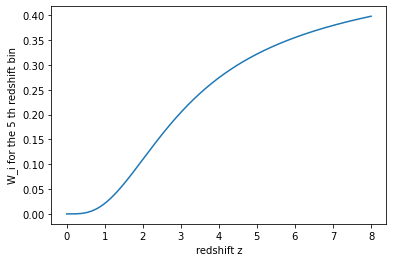

In [53]:
W_i = np.empty(len(z_list))
for z_L_index in range(len(z_list)):
    W_i[z_L_index] = sum(W_L_list[z_L_index]*n_z_all_list)/z_res #using the true redshift distribution
plt.plot(z_list, W_i)
plt.xlabel('redshift z')
plt.ylabel('W_i for the %1i th redshift bin'%i)
plt.show()

In [54]:
%%time
eta = 0
eta_z = np.empty(len(z_list),dtype='float64')
ui = np.empty(len(z_list),dtype='float64')
li = np.empty(len(z_list),dtype='float64')

for z_index in range(len(z_list)):#[int(1.2*z_res)]
    ################
    #Upper integral with out multiplying the volume element (canceled out when dividing)
    #the matrix corr. to p(z,z_g^P)*n_i^P(z_G^P)*n_i^P(z_g^P)*S(z_G^P,z_g^P) #indices: (z_G^P,z_g^P)
    psnn_zGP = np.empty(len(z_i_list),dtype='float64')
    Wppsnn_2D = np.empty((len(z_list),len(z_i_list)),dtype='float64') 
    #Lower integral with out multiplying the volume element (canceled out when dividing)
    #the matrix corr. to p(z,z_g^P)*n_i^P(z_G^P)*n_i^P(z_g^P) #indices: (z_G^P,z_g^P)
    pnn_zGP = np.empty(len(z_i_list),dtype='float64')
    Wppnn_2D = np.empty((len(z_list),len(z_i_list)),dtype='float64') 
    
    for zGP_index in range(len(z_i_list)):
        filterfunction = z_i_list-z_i_list[zGP_index] #filterfunction has entries 0 if zgP-zGP<0
        filterfunction[filterfunction<0]=0
        filterfunction=filterfunction != 0 #False for entries zgP-zGP<0
        #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*S*n*n)@z=z_list[z_index]""
        temp_vec = photozPDF[z_index]*n_z_i_list[zGP_index]*n_z_i_list
        psnn_zGP[zGP_index] = np.sum(temp_vec*filterfunction,dtype='float64')
        #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*n*n)@z=z_list[z_index]""
        pnn_zGP[zGP_index] = np.sum(temp_vec,dtype='float64')
        
    #Adding the z_G variable and double summation
    for zG_index in range(len(z_list)):
        Wppsnn_2D[zG_index] = W_L_list[z_index,zG_index]*photozPDF[zG_index]*psnn_zGP
        Wppnn_2D[zG_index]  = W_L_list[z_index,zG_index]*photozPDF[zG_index]*pnn_zGP
    Wppsnn_2D_sum = 2*np.sum(Wppsnn_2D,dtype='float64')
    Wppnn_2D_sum  = np.sum(Wppnn_2D,dtype='float64') 
#     print(Wppsnn_2D)
#    print(Wppnn_2D_sum,Wppnn_2D_sum)
    if Wppnn_2D_sum == 0: increment = 0
    else: increment = Wppsnn_2D_sum/Wppnn_2D_sum
    
    eta += increment
    eta_z[z_index] = increment
    ui[z_index] = Wppsnn_2D_sum
    li[z_index] = Wppnn_2D_sum

CPU times: user 15.9 s, sys: 96.2 ms, total: 16 s
Wall time: 17.4 s


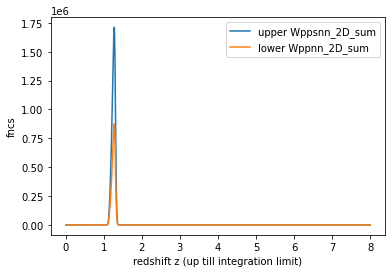

In [55]:
plt.plot(z_list, ui,label='upper Wppsnn_2D_sum')
plt.plot(z_list, li,label='lower Wppnn_2D_sum')

plt.xlabel('redshift z (up till integration limit)')
plt.ylabel('fncs')
#plt.yscale('log')
plt.legend()
plt.show()

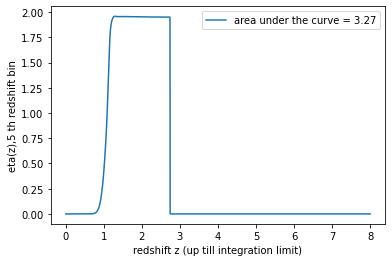

area under the curve = intg(eta) = 3.27


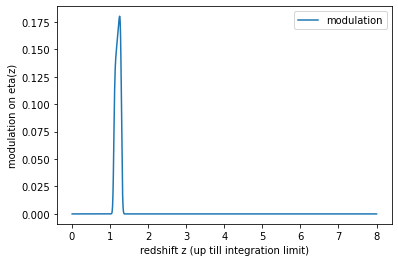

Q = 1.7786213590155107


In [56]:
#v1, z_res = 1000, z_lim = 5, 3.5min
plt.plot(z_list, eta_z,label='area under the curve = %1.2f'%(eta/z_res))
plt.xlabel('redshift z (up till integration limit)')
plt.ylabel('eta(z),%1i th redshift bin'%i)
plt.legend()
plt.show()
print('area under the curve = intg(eta) = %1.2f'%(eta/z_res))

plt.plot(z_list, chi_list*W_i*n_z_i_smeared_list,label='modulation')
plt.xlabel('redshift z (up till integration limit)')
plt.ylabel('modulation on eta(z)')
plt.legend()
plt.show()
#Q factor with delta m = 1
CiiGg = np.sum(chi_list*W_i*n_z_i_smeared_list)/z_res
CiiGgS = np.sum(chi_list*W_i*n_z_i_smeared_list*eta_z)/z_res
# CiiGg = np.sum(chi_list*W_i*n_z_all_list)/z_res
# CiiGgS = np.sum(chi_list*W_i*n_z_all_list*eta_z)/z_res
Q = CiiGgS/CiiGg
print('Q =',Q)